In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.metricBundles as metricBundles
from lsst.sims.photUtils import Sed


In [2]:
dbFile = 'baseline_v1.3_10yrs.db'
# This connection checks which version it thinks the database is and should do the right thing schema-wise
conn = db.OpsimDatabase(dbFile)
outDir='temp'
resultsDb = db.ResultsDb(outDir=outDir)

In [3]:
# Add an extinction cut
class ExgalM5_cut(metrics.BaseMetric):
    """
    Calculate co-added five-sigma limiting depth after dust extinction.

    Uses photUtils
    """
    def __init__(self, m5Col='fiveSigmaDepth', units='mag',
                 lsstFilter='r', wavelen_min=None , wavelen_max=None , wavelen_step=1.,
                 extinction_cut=0.2, depth_cut=26.4, **kwargs ):
        """
        Args:
            m5Col (str): Column name that ('fiveSigmaDepth')
            units (str): units of the metric ('mag')
            lsstFilter (str): Which LSST filter to calculate m5 for
            wavelen_min (float): Minimum wavength of your filter (None)
            wavelen_max (float): (None)
            wavelen_step (float): (1.)
            **kwargs:
        """
        maps = ['DustMap']
        waveMins={'u':330.,'g':403.,'r':552.,'i':691.,'z':818.,'y':950.}
        waveMaxes={'u':403.,'g':552.,'r':691.,'i':818.,'z':922.,'y':1070.}

        if lsstFilter is not None:
            wavelen_min = waveMins[lsstFilter]
            wavelen_max = waveMaxes[lsstFilter]

        self.m5Col = m5Col
        super(ExgalM5_cut, self).__init__(col=[self.m5Col],
                                      maps=maps, units=units, **kwargs)

        testsed = Sed()
        testsed.setFlatSED(wavelen_min = wavelen_min,
                           wavelen_max = wavelen_max, wavelen_step = 1)
        self.a,self.b = testsed.setupCCM_ab()
        self.R_v = 3.1
        self.Coaddm5Metric = metrics.Coaddm5Metric(m5Col=m5Col)
        
        self.extinction_cut = extinction_cut
        self.depth_cut = depth_cut


    def run(self, dataSlice, slicePoint=None):
        """
        Compute the co-added m5 depth and then apply extinction to that magnitude.

        Args:
            dataSlice (np.array):
            slicePoint (dict):
        Returns:
             float that is the dust atennuated co-added m5-depth.
        """
        
        if slicePoint['ebv'] > self.extinction_cut:
            return self.badval

        m5 = self.Coaddm5Metric.run(dataSlice)
        A_x = (self.a[0]+self.b[0]/self.R_v)*(self.R_v*slicePoint['ebv'])
        result = m5-A_x
        if result < self.depth_cut:
            return self.badval
        else:
            return result

In [4]:
class WackySummaryMetric(metrics.BaseMetric):
    def __init__(self, nside, col=None, **kwargs):
        self.nside = nside
        super(WackySummaryMetric, self).__init__(metricName='wacky',col=col, **kwargs)
        if col is None:
            self.col = 'metricdata'
    def run(self, dataSlice, slicePoint=None):
        # let's assume we are running on a coadded depth
        
        # Chop off any outliers
        good_pix = np.where(dataSlice[self.col] > 0)[0]
        area = hp.nside2pixarea(self.nside, degrees=True) * np.size(good_pix)
        median_depth = np.median(dataSlice[self.col][good_pix])
        # Here's some value with strange units of mags*deg^2
        result = area*median_depth
        return result

In [5]:
nside = 64
bundleList = []
sql = 'filter="r"'
metric = ExgalM5_cut()
slicer = slicers.HealpixSlicer(nside=nside)
plotDict = {'colorMax': 27.4, 'colorMin': 20}

summary = [WackySummaryMetric(nside)]
summary.append(metrics.MedianMetric())
bundleList.append(metricBundles.MetricBundle(metric,slicer,sql, plotDict=plotDict, summaryMetrics=summary))

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


Querying database SummaryAllProps with constraint filter="r" for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec']
Found 481373 visits
Running:  ['opsim_ExgalM5_cut_fiveSigmaDepth_r_HEAL']


/Users/yoachim/gitRepos/sims_maf/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:108: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'
/Users/yoachim/gitRepos/sims_maf/python/lsst/sims/maf/maps/dustMap.py:25: UserWarning: Slicer value of nside (64) different from map value (128), using slicer value
  % (slicePoints['nside'],self.nside ))


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "filter="r"" constraint now.
monopole: 26.8267  dipole: lon: 73.0082, lat: -47.6935, amp: 0.181952
Plotting complete.


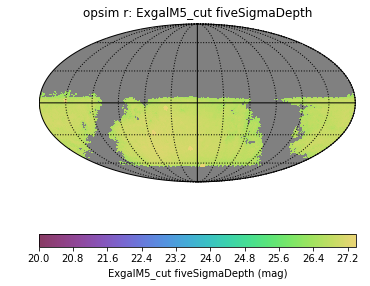

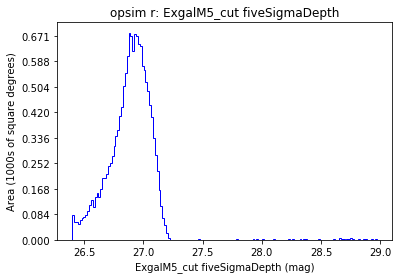

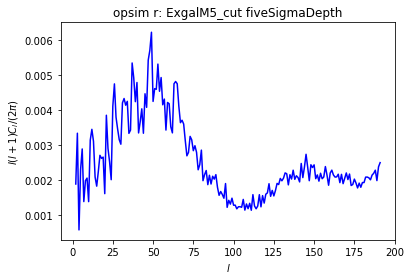

In [6]:
bd = metricBundles.makeBundlesDictFromList(bundleList)
bg = metricBundles.MetricBundleGroup(bd, conn, outDir=outDir, resultsDb=resultsDb)
bg.runAll()

bg.plotAll(closefigs=False)


In [7]:
# And here are the results
bundleList[0].summaryValues

{'Median': 26.903862486987514, 'wacky': 415950.61608928861}